In [2]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression
import graphviz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [92]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
print(len(data))

9093


# remove missing data

In [15]:
# remove all data or year for countries where one of the 3 variables is entirely missing

country_temp_data = {}
country_precip_data = {}

for row in data.iterrows():
    country = row[1].iso
    if country not in country_temp_data:
        country_temp_data[country] = []
    if country not in country_precip_data:
        country_precip_data[country] = []
    country_temp_data[country].append(row[1].UDel_temp_popweight)
    country_precip_data[country].append(row[1].UDel_precip_popweight)

countries_missing_temp = [country for country in country_temp_data if all(np.isnan(country_temp_data[country]))]
countries_missing_precip = [country for country in country_precip_data if all(np.isnan(country_precip_data[country]))]

countries_to_remove = set(countries_missing_temp + countries_missing_precip)

print(countries_to_remove)

indices_to_drop = []
for index, row in enumerate(data.itertuples()):
    if row.iso in countries_to_remove:
        indices_to_drop.append(index)

data_len_before = len(data)
data = data.drop(indices_to_drop)
data = data.reset_index()
print(f"Removed {data_len_before - len(data)} rows for completely missing country data.")

set()
Removed 0 rows for completely missing country data.


In [93]:
# optionally remove all rows with any missing value

indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data_no_missing = data.drop(indices_to_drop)
data = data_no_missing.reset_index()

# data scaling

In [94]:
precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
precip_scaled = precip_scaler.fit_transform(np.array(data.UDel_precip_popweight).reshape(-1,1)).flatten()
gdp_scaled = gdp_scaler.fit_transform(np.array(data.growthWDI).reshape(-1,1)).flatten()
temp_scaled = temp_scaler.fit_transform(np.array(data.UDel_temp_popweight).reshape(-1,1)).flatten()

# linear regression

In [100]:
from sklearn.linear_model import LinearRegression
y = np.array(data.growthWDI).reshape(-1,1)
# x = np.transpose(np.array([data.UDel_temp_popweight,np.square(data.UDel_temp_popweight),data.UDel_precip_popweight,np.square(data.UDel_precip_popweight)]))
x = np.transpose(np.array([data.UDel_temp_popweight,np.square(data.UDel_temp_popweight)]))
model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_)

[[ 8.97770691e-04 -4.34360385e-05]] [0.01905209]


In [103]:
from sklearn.linear_model import LinearRegression
y = np.array(gdp_scaled).reshape(-1,1)
# x = np.transpose(np.array([temp_scaled,np.square(temp_scaled),precip_scaled,np.square(precip_scaled)]))
x = np.transpose(np.array([temp_scaled,np.square(temp_scaled)]))
model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_)

[[-0.09037139 -0.03925769]] [0.03925769]


In [106]:
print((model.coef_[0][0] * np.std(data.growthWDI) / np.std(data.UDel_temp_popweight)) - 2 * (model.coef_[0][1] * np.mean(data.UDel_temp_popweight) * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight))))
print(model.coef_[0][1] * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight)))
# print(.0953 * np.std(data.growthWDI) / np.std(data.UDel_precip_popweight))
# print(.1543 * np.std(data.growthWDI) / np.square(np.std(data.UDel_precip_popweight)))

0.0008977706911867145
-4.343603854139065e-05


# year and country fixed effect coefficient matrices

In [74]:
min_year = min(data.year)
data_len = len(data.year)
year_mult_mat = [np.zeros(data_len) for year in set(data.year)]
country_mult_mat = [np.zeros(data_len) for country in set(data.iso)]
country_index = -1
curr_country = ""
for row_index, row in enumerate(data.itertuples()):
    if row.iso != curr_country:
        country_index += 1
        curr_country = row.iso
    year_index = row.year - min_year
    country_mult_mat[country_index][row_index] = 1
    year_mult_mat[year_index][row_index] = 1
country_mult_mat[0] = [1 for i in range(len(data))]

In [7]:
# gradual year-by-year effects
grad_effects_data = np.transpose(np.array(data.loc[:, data.columns.str.startswith(('_y'))]))

In [75]:
np.transpose(country_mult_mat)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [37]:
with pm.Model() as model:

    gdp_intercept = pm.Normal("gdp_intercept", 0,5)
    temp_gdp_coef = pm.Normal('temp_gdp_coef',0,1)
    temp_sq_gdp_coef = pm.Normal('temp_sq_gdp_coef',0,1)
    precip_gdp_coef = pm.Normal("precip_gdp_coef",0,1)
    precip_sq_gdp_coef = pm.Normal("precip_sq_gdp_coef",0,1)

    # country_coefs = pm.Normal("country_coefs", 0, 5, shape=(len(set(data.iso))))
    # country_fixed_effects = pt.dot(pt.transpose(country_mult_mat),country_coefs)

    gdp_prior = pm.Deterministic(
        "gdp_prior",
        gdp_intercept +
        (temp_gdp_coef * temp_scaled) +
        (temp_sq_gdp_coef * pt.sqr(temp_scaled)) +
        (precip_gdp_coef * precip_scaled) +
        (precip_sq_gdp_coef * pt.sqr(precip_scaled)) #+
        # country_fixed_effects
    )

    gdp_std = pm.HalfNormal('gdp_std', sigma=1)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=gdp_scaled)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(target_accept=.99)
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [gdp_intercept, gdp_posterior, gdp_std, precip_gdp_coef, precip_sq_gdp_coef, temp_gdp_coef, temp_sq_gdp_coef]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gdp_intercept, temp_gdp_coef, temp_sq_gdp_coef, precip_gdp_coef, precip_sq_gdp_coef, gdp_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Sampling: [gdp_posterior]


In [117]:
# model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-missing-rows-imputed-hierarchical-country-priors-no-intercept.pkl')
model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-missing-rows-imputed-hierarchical-country-priors.pkl')
# model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-missing-rows-imputed-hierarchical-country-priors-predictor-unscaled.pkl')
# model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-missing-rows-omitted-deterministic-observed.pkl')
trace = model["trace"]
prior = model["prior"]
posterior = model["posterior"]
precip_scaler = model["precip_scaler"]
gdp_scaler = model["gdp_scaler"]
temp_scaler = model["temp_scaler"]

In [76]:
# az.summary(trace, var_names=["temp_gdp_coef","precip_gdp_coef","gdp_intercept"])
az.summary(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
temp_gdp_coef,-0.637,0.217,-1.021,-0.219,0.008,0.006,680.0,1343.0,1.01
temp_sq_gdp_coef,-0.452,0.089,-0.609,-0.273,0.002,0.001,1789.0,2590.0,1.00
precip_gdp_coef,0.050,0.063,-0.068,0.169,0.001,0.001,3535.0,2558.0,1.00
precip_sq_gdp_coef,-0.042,0.022,-0.085,-0.002,0.000,0.000,4893.0,3167.0,1.00


In [80]:
# az.summary(trace, var_names=["temp_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef","gdp_intercept"])
az.summary(trace, var_names=["country_coefs"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
country_coefs[0],0.589,0.262,0.091,1.103,0.075,0.054,13.0,23.0,1.22
country_coefs[1],-0.456,0.336,-1.124,0.127,0.078,0.056,19.0,66.0,1.14
country_coefs[2],-0.387,0.308,-0.983,0.187,0.075,0.054,17.0,36.0,1.16
country_coefs[3],-0.840,0.377,-1.584,-0.195,0.078,0.056,23.0,117.0,1.12
country_coefs[4],-0.640,0.284,-1.182,-0.096,0.069,0.050,17.0,33.0,1.16
...,...,...,...,...,...,...,...,...,...
country_coefs[161],-0.339,0.360,-1.024,0.317,0.071,0.050,26.0,131.0,1.10
country_coefs[162],-0.600,0.281,-1.169,-0.111,0.070,0.050,16.0,32.0,1.16
country_coefs[163],-1.211,0.332,-1.834,-0.617,0.084,0.062,16.0,50.0,1.17
country_coefs[164],-0.900,0.306,-1.492,-0.353,0.076,0.055,16.0,42.0,1.16


/tmp/ipykernel_16949/189355448.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


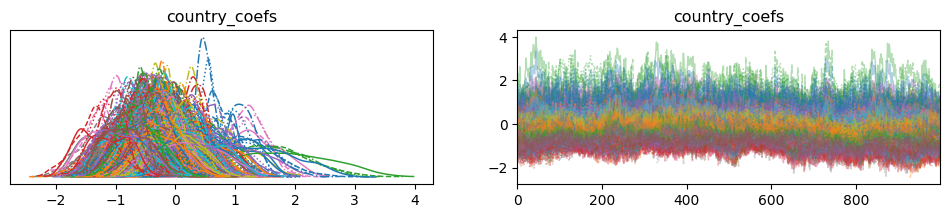

In [81]:
fig = az.plot_trace(trace, var_names=["country_coefs"]).ravel()[0].figure
fig.show()

In [30]:
fig = az.plot_ppc(posterior,var_names=["gdp_posterior_observed"]).ravel()[0].figure
fig.show()

KeyError: 'var names: "[\'grad_effect_coefs\'] are not present" in dataset'

/tmp/ipykernel_7792/1703580941.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


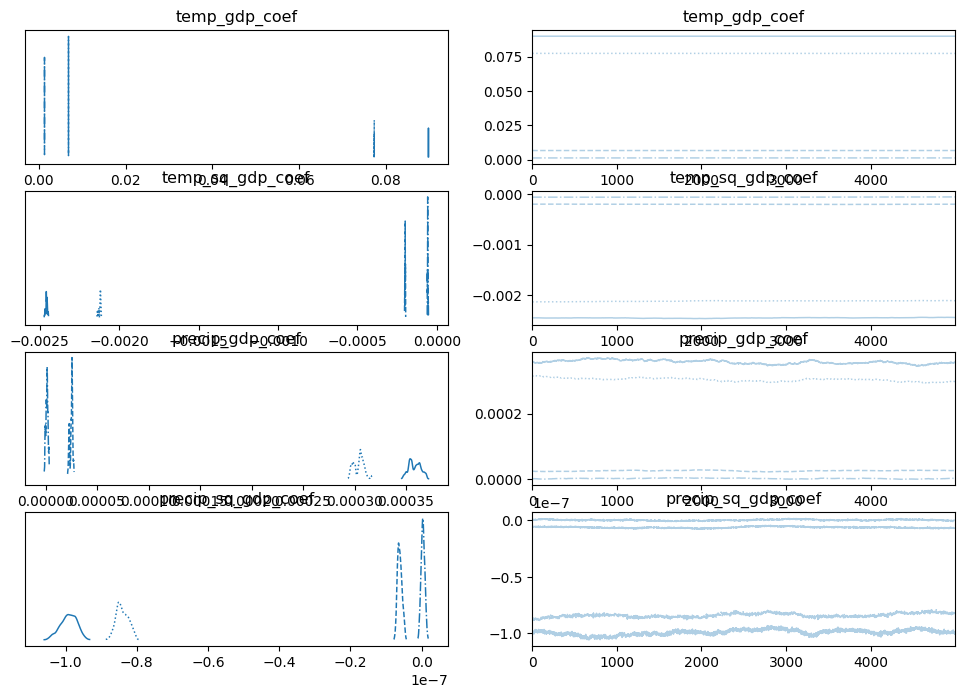

In [215]:
fig = az.plot_trace(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef"]).ravel()[0].figure
fig.show()

# Reproduce 13C threshold with probabilistic model

In [118]:
coef1 = trace.posterior.temp_gdp_coef.data.flatten()
coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
coef3 = trace.posterior.precip_gdp_coef.data.flatten()
coef4 = trace.posterior.precip_sq_gdp_coef.data.flatten()
coef1 = (coef1 * np.std(data.growthWDI) / np.std(data.UDel_temp_popweight)) - (2 * (coef2 * np.mean(data.UDel_temp_popweight * np.std(data.growthWDI)) / np.square(np.std(data.UDel_temp_popweight))))
coef2 = (coef2 * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight)))
coef3 = (coef3 * np.std(data.growthWDI) / np.std(data.UDel_precip_popweight)) - (2 * (coef4 * np.mean(data.UDel_precip_popweight * np.std(data.growthWDI)) / np.square(np.std(data.UDel_precip_popweight))))
coef4 = (coef4 * np.std(data.growthWDI)) / np.square(np.std(data.UDel_precip_popweight))
numerator = [val for val in coef1]
denominator = [-2*(val) for val in coef2]
res = np.array(numerator) / np.array(denominator)
print(np.mean(res), np.mean(res) - np.std(res) * 1.645, np.mean(res) + np.std(res) * 1.645)

14.603818869249652 11.087084397903311 18.120553340595993


In [116]:
# where does the original 13C estimate fall?
zscore = (13.06 - np.mean(res)) / np.std(res)
print(zscore)

-0.370716733649298


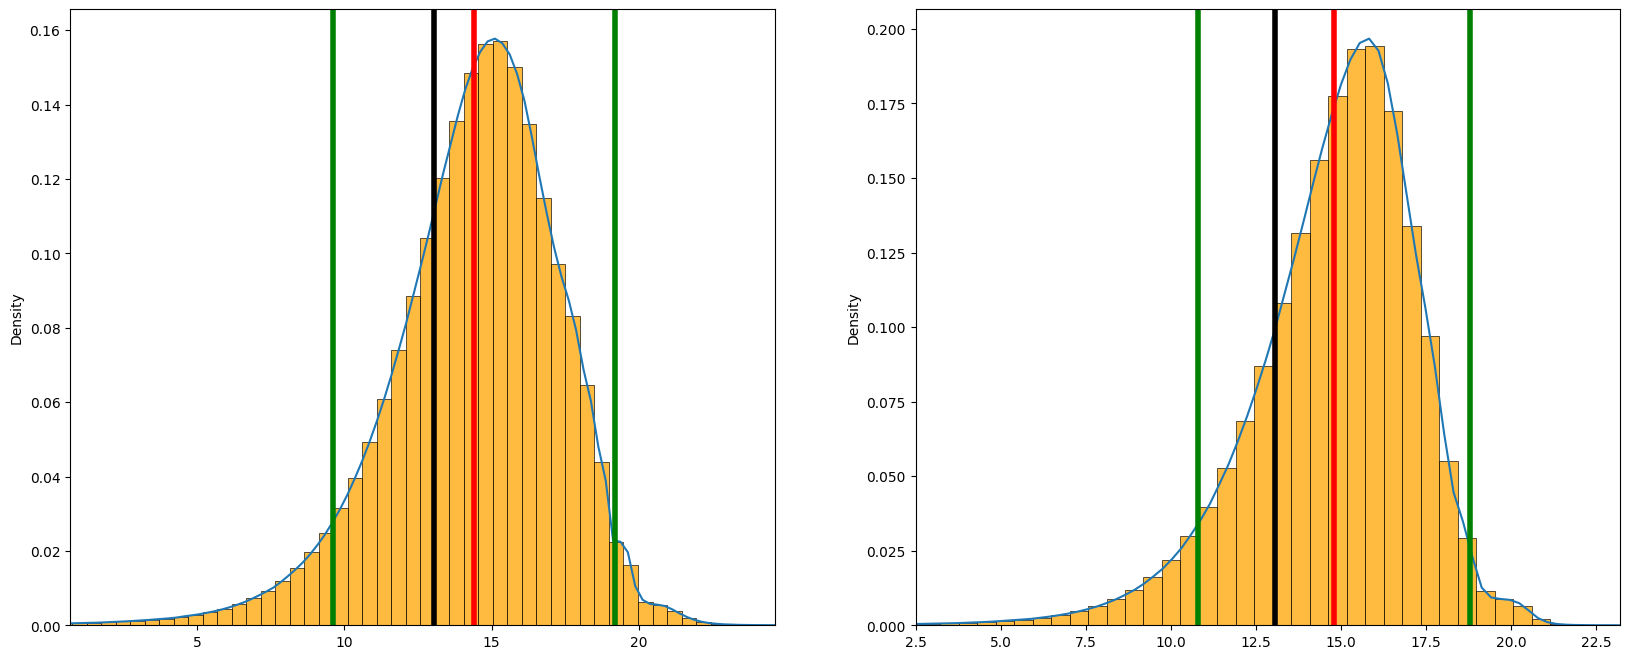

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

x = np.linspace(np.mean(res) - 3*np.std(res), np.mean(res) + 3*np.std(res), 100)
sns.histplot(res,bins=100,color="orange",stat="density", ax=ax1)
# plt.plot(x, stats.norm.pdf(x, np.mean(res), np.std(res)), color="blue")
sns.kdeplot(res, ax=ax1)
ax1.axvline(x = np.mean(res), color = 'r', lw = 4, label = 'axvline - full height')
ax1.axvline(x = np.mean(res) - np.std(res) * 1.645, color = 'g', lw = 4, label = 'axvline - full height')
ax1.axvline(x = np.mean(res) + np.std(res) * 1.645, color = 'g', lw = 4, label = 'axvline - full height')
ax1.axvline(x = 13.06, color = 'k', lw = 4, label = 'axvline - full height')
ax1.set_xlim(min(x)-5, max(x)+1.5)

x = np.linspace(np.mean(res2) - 3*np.std(res2), np.mean(res) + 3*np.std(res2), 100)
sns.histplot(res2,bins=100,color="orange",stat="density", ax=ax2)
# plt.plot(x, stats.norm.pdf(x, np.mean(res), np.std(res)), color="blue")
sns.kdeplot(res2, ax=ax2)
ax2.axvline(x = np.mean(res2), color = 'r', lw = 4, label = 'axvline - full height')
ax2.axvline(x = np.mean(res2) - np.std(res2) * 1.645, color = 'g', lw = 4, label = 'axvline - full height')
ax2.axvline(x = np.mean(res2) + np.std(res2) * 1.645, color = 'g', lw = 4, label = 'axvline - full height')
ax2.axvline(x = 13.06, color = 'k', lw = 4, label = 'axvline - full height')
ax2.set_xlim(min(x)-5, max(x)+1.5)

plt.show()
# plt.savefig("../figures/burke_reproduction_pdf.png")

# Scaled coefs for error estimation

In [11]:
print(np.mean(mult1*coef1))
print(np.std(mult1*coef1))
print(np.mean(mult2*coef2))
print(np.std(mult2*coef2))
print(np.mean(mult3*coef3))
print(np.std(mult3*coef3))
print(np.mean(mult4*coef4))
print(np.std(mult4*coef4))

0.0009992987682286047
0.0003539394893837055
-5.1253894660406745e-05
1.0137098523300436e-05
4.16911114081315e-06
5.192943994516138e-06
-3.784829953989272e-10
2.0221372426588823e-10


# Burke et al. Uncertainty Bounds

In [120]:
burke_temp_coef = .0127183
burke_temp2_coef = -.0004871
burke_temp_error = .0037876
burke_temp2_error = .0001184

lower_bound = (burke_temp_coef - burke_temp_error ) / (-2 * (burke_temp2_coef - burke_temp2_error))
upper_bound = (burke_temp_coef + burke_temp_error ) / (-2 * (burke_temp2_coef + burke_temp2_error))
mean = burke_temp_coef / (-2 * burke_temp2_coef)
print(lower_bound)
print(upper_bound)
print(mean)

7.374649050371593
22.383916463249253
13.05512215150893
